# Курсовой проект для курса "Python для Data Science"

Задание: Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

Целевая переменная: Price

Основная метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Вспомогательная метрика: MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

### Загрузка библиотек

In [1]:
import datetime # для работы со времнем
import gc # сборщик мусора
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')
%matplotlib inline

### Загрузка данных и уменьшение объема памяти, который занимает датасет

In [2]:
DATASET_PATH = 'P:\Обучение\Домашка по библиотекам Python\КП по Python_for_Data_Science/train.csv'
TEST_DATASET_PATH = 'P:\Обучение\Домашка по библиотекам Python\КП по Python_for_Data_Science/test.csv'

In [3]:
df = pd.read_csv(DATASET_PATH)

In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [5]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [7]:
X = df.copy()
y = df[['Price']]

X_final = pd.read_csv(TEST_DATASET_PATH)

In [8]:
X_final.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [9]:
reduce_mem_usage(X_final)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263184,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597818,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809795,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198471,21.807060,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282623,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [10]:
# сразу создам
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()

Строк в трейне: 10000
Строк в тесте 5000


20

In [11]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250


In [12]:
X_final.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
15856,74,2.0,69.263184,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5480,190,1.0,13.597818,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


### Обработка датасета

In [13]:
class Data:
    
    def __init__(self):
        """Константы для обработки выбросов на основе анализа данных"""
        self.Square_min = 15
        self.Square_max = 300
        
        self.LifeSquare_min = 10
        self.LifeSquare_max = 280
        
        self.Rooms_min = 1
        self.Rooms_max = 5
        
        self.HouseFloor_min = 1
        self.HouseFloor_max = 50
        
        self.KitchenSquare_min = 3
        self.KitchenSquare_max = 30
        
        self.current_year = datetime.datetime.now().year
        
        self.medians = None
        self.DistrictId_value_counts = None
        self.SquareMeterPrice_by_DistrictId = None
        self.Healthcare_1_by_DistrictId = None
        
        
    def fit(self, df):
        
        # медианные значения
        self.medians = df[['LifeSquare', 'HouseFloor']].median()
        
        # подсчет популярных районов
        self.DistrictId_value_counts = dict(df['DistrictId'].value_counts())
        
        # подсчет средней цены за м2 по району
        df_temp = df.loc[((df['Square'] > self.Square_min) & (df['Square'] < self.Square_max))]
        df_temp["SquareMeterPrice"] = df_temp["Price"] / df_temp["Square"]
        self.SquareMeterPrice_by_DistrictId = df_temp.groupby('DistrictId', as_index=False)\
            .agg({'SquareMeterPrice': 'mean'})\
            .rename(columns={'SquareMeterPrice': 'AverageSquareMeterPrice'})
        
        # подсчет среднего значения признака Healthcare_1 по району
        self.Healthcare_1_by_DistrictId = df.groupby('DistrictId', as_index=False)\
            .agg({'Healthcare_1': 'mean'})\
            .rename(columns={'Healthcare_1': 'AverageHealthcare_1'})
        
        del df_temp
        
    def transform(self, df):
        
        # Обработка пропусков
        df[['LifeSquare', 'HouseFloor']] = df[['LifeSquare', 'HouseFloor']].fillna(self.medians)
        
        # Обработка выбросов
        
        # площадь
        df.loc[(df['Square'] > self.Square_max), 'Square'] = self.Square_max
        df.loc[(df['Square'] < self.Square_min), 'Square'] = self.Square_min
        
        # жилая площадь
        df.loc[(df['LifeSquare'] < self.LifeSquare_min), 'LifeSquare'] = self.LifeSquare_min
        df.loc[(df['LifeSquare'] > self.LifeSquare_max), 'LifeSquare'] = self.LifeSquare_max
        
        # площадь кухни
        df.loc[(df['KitchenSquare'] < self.KitchenSquare_min), 'KitchenSquare'] = self.KitchenSquare_min
        df.loc[(df['KitchenSquare'] > self.KitchenSquare_max), 'KitchenSquare'] = self.KitchenSquare_max
        
        # год постройки дома
        df.loc[(df['HouseYear'] > self.current_year), 'HouseYear'] = self.current_year
        
        # количество комнат
        df.loc[(df['Rooms'] > self.Rooms_max), 'Rooms'] = self.Rooms_max
        df.loc[(df['Rooms'] < self.Rooms_min), 'Rooms'] = self.Rooms_min
        
        # количество этажей
        df.loc[(df['HouseFloor'] < self.HouseFloor_min), 'HouseFloor'] = self.HouseFloor_min
        df.loc[(df['HouseFloor'] > self.HouseFloor_max), 'HouseFloor'] = self.HouseFloor_max
        
        # если этаж больше этажности дома, то присваиваем случайный этаж от self.HouseFloor_min до максимального этажа в доме
        floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
        df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: self.HouseFloor_min if (self.HouseFloor_min == x) else np.random.randint(self.HouseFloor_min, x))
        
        # Обработка категорий
        df = pd.concat([df, pd.get_dummies(df['Ecology_2'], prefix='Ecology_2', dtype='int8')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Ecology_3'], prefix='Ecology_3', dtype='int8')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Shops_2'], prefix='Shops_2', dtype='int8')], axis=1)
        
        return df
    
    def features(self, df):
        
        # добавление признака популярности района
        df['DistrictId_counts'] = df['DistrictId'].map(self.DistrictId_value_counts)
        df['DistrictId_counts'].fillna(df['DistrictId_counts'].median(), inplace=True)
        
        # добавление признака средней стоимости м2 по району
        df = df.merge(self.SquareMeterPrice_by_DistrictId, on=["DistrictId"], how='left')
        df['AverageSquareMeterPrice'].fillna(df['AverageSquareMeterPrice'].median(), inplace=True)
        
        # добавление признака среднего значения Healthcare_1 по району
        df = df.merge(self.Healthcare_1_by_DistrictId, on=["DistrictId"], how='left')
        df['AverageHealthcare_1'].fillna(df['AverageHealthcare_1'].median(), inplace=True)
        df['SQUARE_LIFE'] = (df['Square'] / df['LifeSquare'])
        df['SQUARE_KIT'] = (df['Square'] / df['KitchenSquare'])
        df['SQUARE_ROOM'] = (df['LifeSquare'] / df['Rooms'])

        
        return df

### Деление данных на тренировочные и валидационные

In [14]:
data_inst = Data()

# тренировочные данные
data_inst.fit(X)
X = data_inst.transform(X)
X = data_inst.features(X)

# валидационные данные
X_final = data_inst.transform(X_final)
X_final = data_inst.features(X_final)

### Анализ признаков

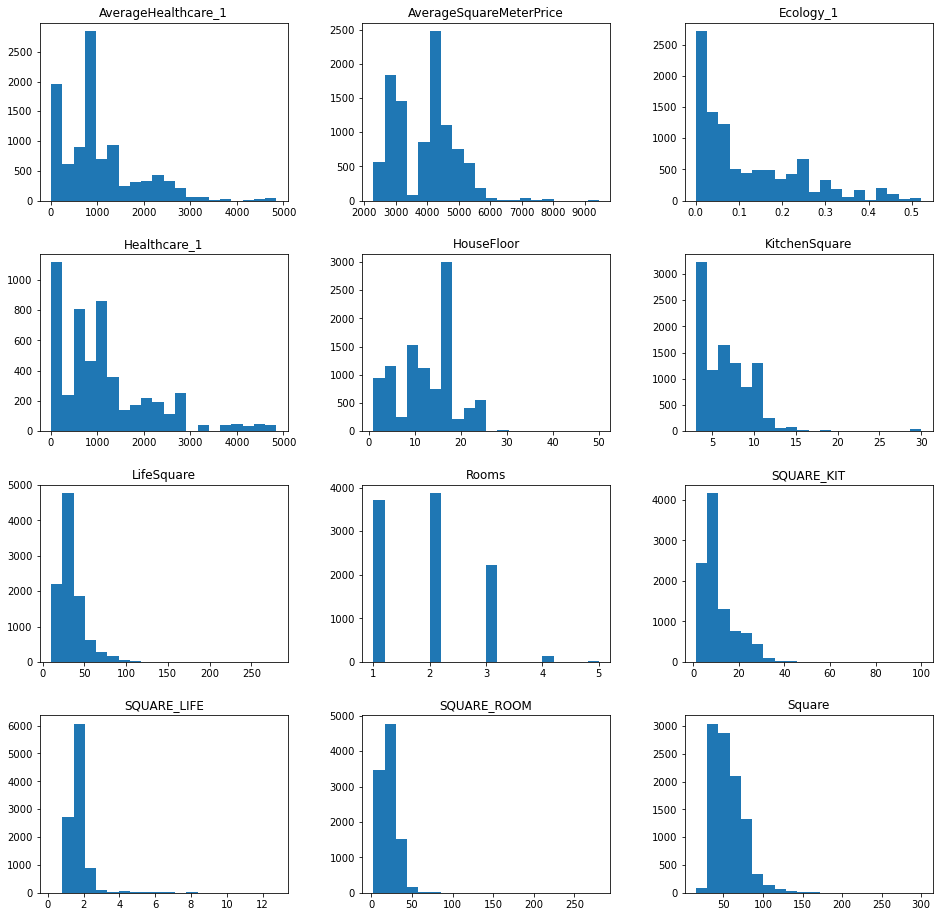

In [15]:
X_num_features = X.select_dtypes(include=['float64', 'float32', 'float16'])
X_num_features.drop('Price', axis=1, inplace=True)

X_num_features.hist(figsize=(16,16), bins=20, grid=False);

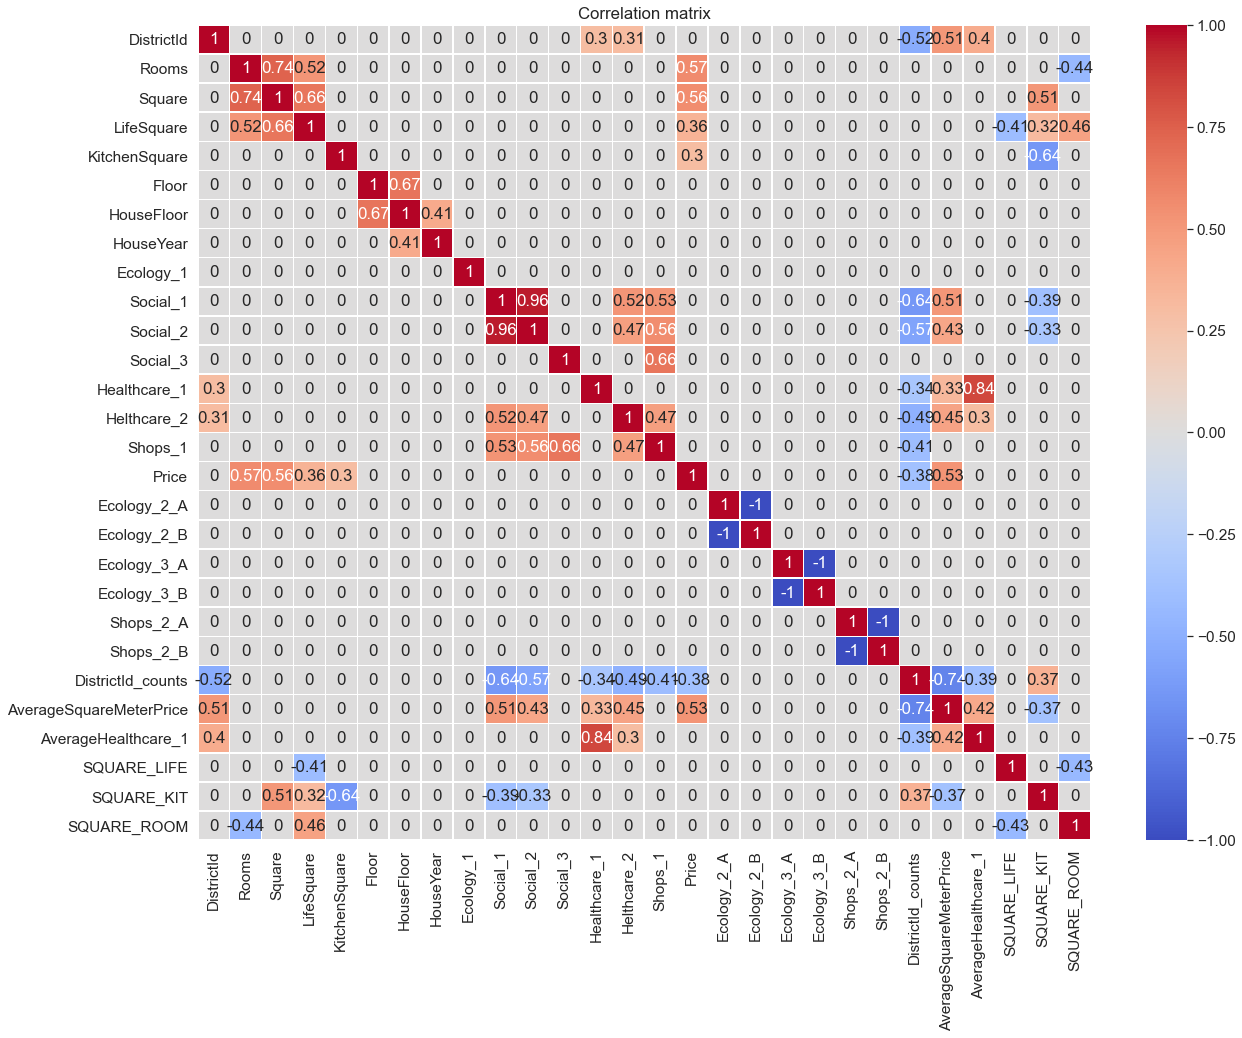

In [16]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)

corr_matrix = X.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### Анализ зависимости таргета от признаков

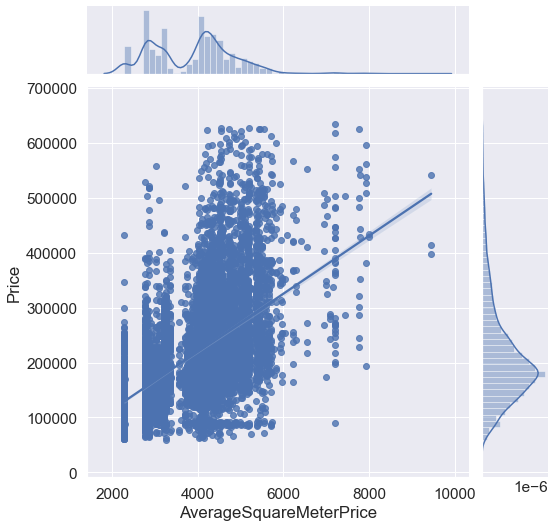

In [17]:
grid = sns.jointplot(X['AverageSquareMeterPrice'], X['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

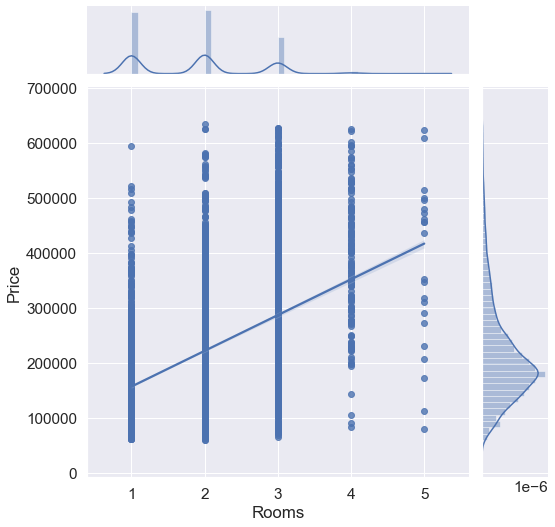

In [18]:
grid = sns.jointplot(X['Rooms'], X['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

##### Далее я просмотрел множество зависимостей и, чтобы не нагромождать графиков, выделил, по моему мнению самые важные, которые и взял далее. После я их проверил на важность.

### Определение необходимых признаков

In [19]:
feature_names = ['AverageSquareMeterPrice', 'DistrictId_counts', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
                    'HouseFloor', 'HouseYear', 'Helthcare_2', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                    'Shops_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B',
                    'AverageHealthcare_1', 'SQUARE_LIFE', 'SQUARE_KIT', 'SQUARE_ROOM',]


X1 = X[feature_names]
X1_final = X_final[feature_names]

### Модель

In [20]:
model = LGBMRegressor(max_depth=5,
                             n_estimators=150,
                             num_leaves=150,
                             random_state=42)

cv_score = cross_val_score(model, X1, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=6, shuffle=True, random_state=42))

model.fit(X1, y)
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.760 +- 0.023


#### Проверим важность признаков в модели

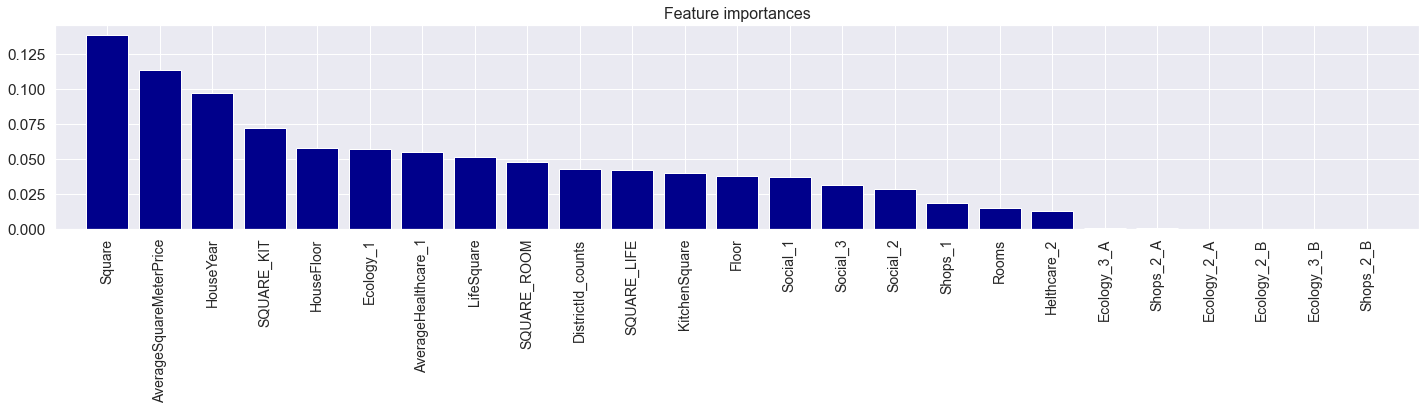

In [21]:
def plot_feature_importances(importances, X1):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X1.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X1.shape[1]), X1.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X1.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X1=X1)

### Сохранение модели

In [22]:
y_pred_final = model.predict(X1_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('AlexBond.csv', index=False)

preds_final.head()

,Id,Price
0,725,161476.979856
1,15856,222079.373318
2,5480,264869.998772
3,15664,340827.023482
4,14275,139971.313105
